In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

## Gather Data

In [3]:
df = pd.read_csv("2020survey_results_public.csv")
schema = pd.read_csv("survey_results_schema.csv")

In [4]:
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


## Business Understanding

We often get stuck on problems or have issues with code while we are working. Let's see how if we can get some insights on how different developers approach problems when they are stuck.

Below we will take a look at some questions related to this:

In [5]:
print(list(schema[schema['Column']=='DevType']['QuestionText']))
print(list(schema[schema['Column']=='NEWStuck']['QuestionText']))

['Which of the following describe you? Please select all that apply.']
['What do you do when you get stuck on a problem? Select all that apply.']


## Data Understanding

In [6]:
df.DevType.value_counts().reset_index()


,index,DevType
0,"Developer, full-stack",4424
1,"Developer, back-end",3086
2,"Developer, back-end;Developer, front-end;Devel...",2227
3,"Developer, back-end;Developer, full-stack",1476
4,"Developer, front-end",1401
...,...,...
8264,"Developer, full-stack;Developer, game or graph...",1
8265,Academic researcher;Data or business analyst;D...,1
8266,"Engineer, data;Engineer, site reliability;Prod...",1
8267,Data or business analyst;DevOps specialist;Sys...,1


In [7]:
df.NEWStuck.value_counts().reset_index()

,index,NEWStuck
0,Visit Stack Overflow,2904
1,Visit Stack Overflow;Watch help / tutorial videos,2862
2,Call a coworker or friend;Visit Stack Overflow...,2833
3,Call a coworker or friend;Visit Stack Overflow...,2343
4,Call a coworker or friend;Visit Stack Overflow,2205
...,...,...
439,Meditate;Play games;Go for a walk or other phy...,1
440,Meditate;Play games;Go for a walk or other phy...,1
441,Meditate;Play games;Call a coworker or friend;...,1
442,Play games;Visit Stack Overflow;Go for a walk ...,1


We can see that the data is a bit messy, so let's clean it up a bit.

## Data Preparation

In [9]:
### List of what respondents do when they're stuck on a problem.
messy_stuck = list(df.groupby('NEWStuck').mean().index)
messy_stuck

['Call a coworker or friend',
 'Call a coworker or friend;Do other work and come back later',
 'Call a coworker or friend;Do other work and come back later;Visit another developer community (please name):',
 'Call a coworker or friend;Go for a walk or other physical activity',
 'Call a coworker or friend;Go for a walk or other physical activity;Do other work and come back later',
 'Call a coworker or friend;Go for a walk or other physical activity;Do other work and come back later;Visit another developer community (please name):',
 'Call a coworker or friend;Go for a walk or other physical activity;Panic',
 'Call a coworker or friend;Go for a walk or other physical activity;Panic;Do other work and come back later',
 'Call a coworker or friend;Go for a walk or other physical activity;Panic;Do other work and come back later;Visit another developer community (please name):',
 'Call a coworker or friend;Go for a walk or other physical activity;Panic;Watch help / tutorial videos',
 'Call a 

Let's create a function to clean up this list 

In [11]:
def clean_list(my_list):
    '''
    INPUT:
    List - list that you want to clean up
    
    OUTPUT:
    New List - new list that split the strings in the old list and extended into a new one
    '''
    new_list = []
    for i in my_list:
        new = i.split(';')
        new_list.extend(list(new))
    return list(set(new_list))
clean_stuck = clean_list(messy_stuck)

Let's create a dataframe that shows what the developer does when they are stuck on a problem and the amount of people that do the same thing

In [12]:
def count_response(df, new_clean_list):
    '''
    INPUT:
    df - dataframe that you want look through
    new_clean_list - list of strings that you want to search for
    
    OUTPUT:
    new_df - dataframe that consists of responses and the count of how many times they appear
    '''
    d = defaultdict(int)
    df_newstuck = df['NEWStuck'].value_counts().reset_index()
    for i in new_clean_list:
        for j in range(df_newstuck.shape[0]):
            if i in df_newstuck['index'][j]:
                d[i] += int(df_newstuck['NEWStuck'][j])
    new_df = pd.DataFrame.from_dict(d,orient='index',columns=['Count of Response'])
    return new_df.sort_values(by='Count of Response',ascending=False)
df_response_count = count_response(df, clean_stuck)
df_response_count

,Count of Response
Visit Stack Overflow,49803
Do other work and come back later,29913
Watch help / tutorial videos,29010
Call a coworker or friend,27425
Go for a walk or other physical activity,23800
Play games,8265
Meditate,6440
Panic,6011
Visit another developer community (please name):,5640


Nice! We can see that "Visit Stack Overflow" is what most developers use when they are stuck on a problem. Let's graph this dataframe for better visualization.

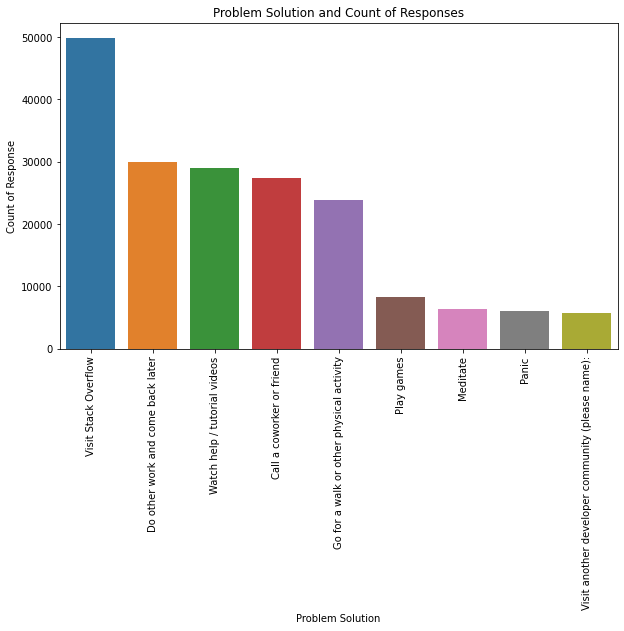

In [13]:
### Visualize what respondents do when they're stuck on problem and the count of how many respondents said the response.
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
graph_responses = sns.barplot(x=df_response_count.index, y = df_response_count['Count of Response'], ax=ax)
graph_responses.set_xticklabels(graph_responses.get_xticklabels(),rotation=90);
graph_responses.set(xlabel='Problem Solution')
graph_responses.set_title("Problem Solution and Count of Responses");

## Evaluation

We can see that first option for majority of developers is to visit stack overflow. What I found interesting was that other people go and do something else and comeback to the problem later. This is interesting because when I took a course called "Learning How To Learn" by Barabara Oakly they also advised that if you are stuck on a problem you should take time away and do something else. Your brain subconciously will be working on it, so when you comeback with fresh eyes you might find that you have an easier time solving it.